In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,MiniBatchKMeans
from sklearn.model_selection import train_test_split,KFold,RandomizedSearchCV
 
# Models
from sklearn.ensemble import StackingRegressor
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
import seaborn as sns
import folium
sns.set(style='darkgrid')
pd.set_option('display.max_columns', None)

* **id** - a unique identifier for each trip
* **vendor_id** - a code indicating the provider associated with the trip record
* **pickup_datetime** - date and time when the meter was engaged
* **dropoff_datetime** - date and time when the meter was disengaged
* **passenger_count** - the number of passengers in the vehicle (driver entered value)
* **pickup_longitude** - the longitude where the meter was engaged
* **pickup_latitude** - the latitude where the meter was engaged
* **dropoff_longitude** - the longitude where the meter was disengaged
* **dropoff_latitude** - the latitude where the meter was disengaged
* **store_and_fwd_flag** - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* **trip_duration** - duration of the trip in seconds

In [2]:
train = pd.read_csv('/kaggle/input/nyc-taxi-trip-duration/train.zip')
test = pd.read_csv('/kaggle/input/nyc-taxi-trip-duration/test.zip')
print(f'Total train rows: {train.shape[0]}')
print(f'Total test rows: {test.shape[0]}')

Total train rows: 1458644
Total test rows: 625134


In [3]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [5]:
train.describe(include = 'all')

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
count,1458644,1.458644e+06,1458644,1458644,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1458644,1.458644e+06
unique,1458644,NaN,1380222,1380377,NaN,NaN,NaN,NaN,NaN,2,NaN
top,id2875421,NaN,2016-03-04 08:07:34,2016-02-19 19:25:04,NaN,NaN,NaN,NaN,NaN,N,NaN
freq,1,NaN,5,5,NaN,NaN,NaN,NaN,NaN,1450599,NaN
mean,NaN,1.534950e+00,NaN,NaN,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,NaN,9.594923e+02
std,NaN,4.987772e-01,NaN,NaN,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,NaN,5.237432e+03
min,NaN,1.000000e+00,NaN,NaN,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,NaN,1.000000e+00
25%,NaN,1.000000e+00,NaN,NaN,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,NaN,3.970000e+02
50%,NaN,2.000000e+00,NaN,NaN,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,NaN,6.620000e+02
75%,NaN,2.000000e+00,NaN,NaN,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,NaN,1.075000e+03


* id column has all unique values for both train and test sets
* vendor_id has only 2 unique values (1 or 2) with a median of 2
* passenger_count has 9 unique values (0,1,2,3,4,5,6,7,8 or 9) with a median of 1
* store_and_fwd_flag has 2 unique values (Y or N)

In [6]:
# check for missing values -> No missing values found
print('Checking for missing data in train:')
print('Missing values found:',train.isna().sum().sum())
print('-'*30)
print('Checking for missing data in test:')
print('Missing values found:',test.isna().sum().sum())

Checking for missing data in train:
Missing values found: 0
------------------------------
Checking for missing data in test:
Missing values found: 0


In [7]:
# parsing dates and checking for consistent trip_duration values
# train
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
train['pickup_date'] = pd.to_datetime(train['pickup_datetime'].dt.date)
train['weekday'] = train['pickup_datetime'].dt.weekday
train['pickup_hour'] = train['pickup_datetime'].dt.hour
train['pickup_month'] = train['pickup_datetime'].dt.month
train['day_of_year'] = train['pickup_datetime'].dt.dayofyear
train['date'] = pd.to_datetime(train['pickup_datetime'].dt.date)
train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'])
train['dropoff_date'] = pd.to_datetime(train['dropoff_datetime'].dt.date)

#total duration in seconds
train['calculated_duration'] = (train['dropoff_datetime'] - train['pickup_datetime']).dt.total_seconds() 
inconsistent_trips_indices = train[(np.abs(train['calculated_duration'] - train['trip_duration'])) > 1].index

# test
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])
test['pickup_date'] = pd.to_datetime(test['pickup_datetime'].dt.date)
test['weekday'] = test['pickup_datetime'].dt.weekday
test['pickup_hour'] = test['pickup_datetime'].dt.hour
test['pickup_month'] = test['pickup_datetime'].dt.month
test['day_of_year'] = test['pickup_datetime'].dt.dayofyear
test['date'] = pd.to_datetime(test['pickup_datetime'].dt.date)


print(f'Inconsistent trip durations found at indices: {inconsistent_trips_indices}') if (len(inconsistent_trips_indices) > 0) else print('All Trip durations are OK!!')
train.drop(['calculated_duration'],axis=1,inplace=True)

All Trip durations are OK!!


Text(0, 0.5, 'Trips')

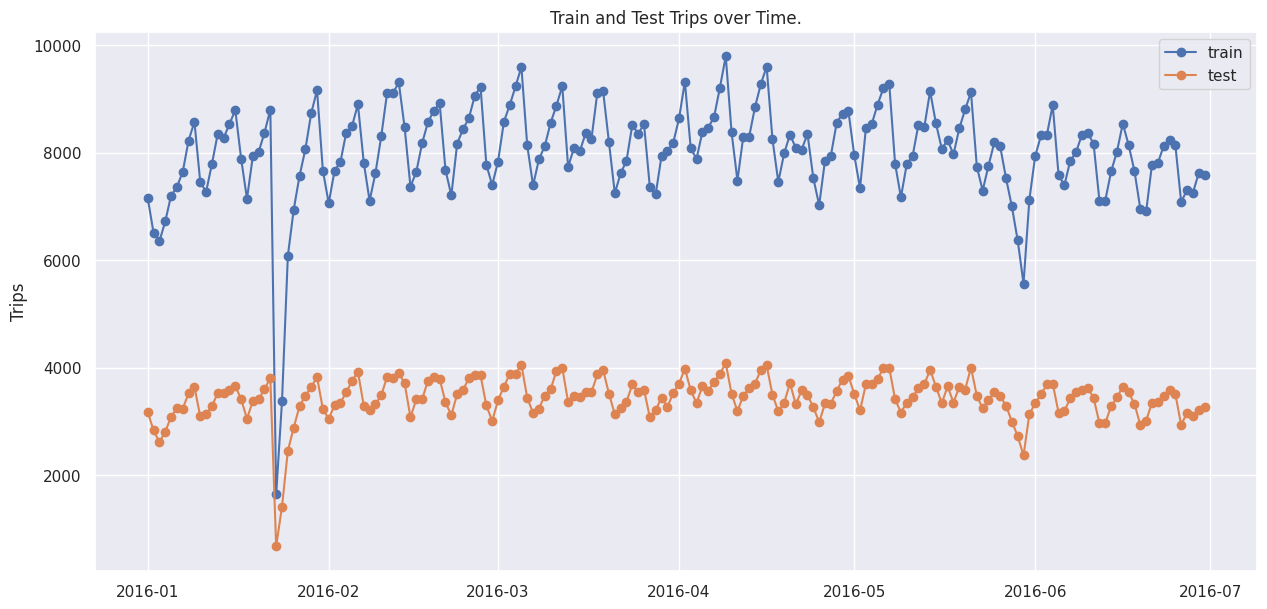

In [8]:
# check train and test overlap - to make sure that we are really training on features that are relevant to our test data set 
train['pickup_date'] = pd.to_datetime(pd.to_datetime(train['pickup_datetime']).dt.date)
test['pickup_date'] = pd.to_datetime(pd.to_datetime(test['pickup_datetime']).dt.date)

fig,ax1 = plt.subplots(1,1,figsize=(15,7))
plt.plot(train.groupby('pickup_date').count()[['vendor_id']], 'o-', label='train')
plt.plot(test.groupby('pickup_date').count()[['vendor_id']], 'o-', label='test')
ax1.set_title('Train and Test Trips over Time.')
ax1.legend(loc=0)
ax1.set_ylabel('Trips')

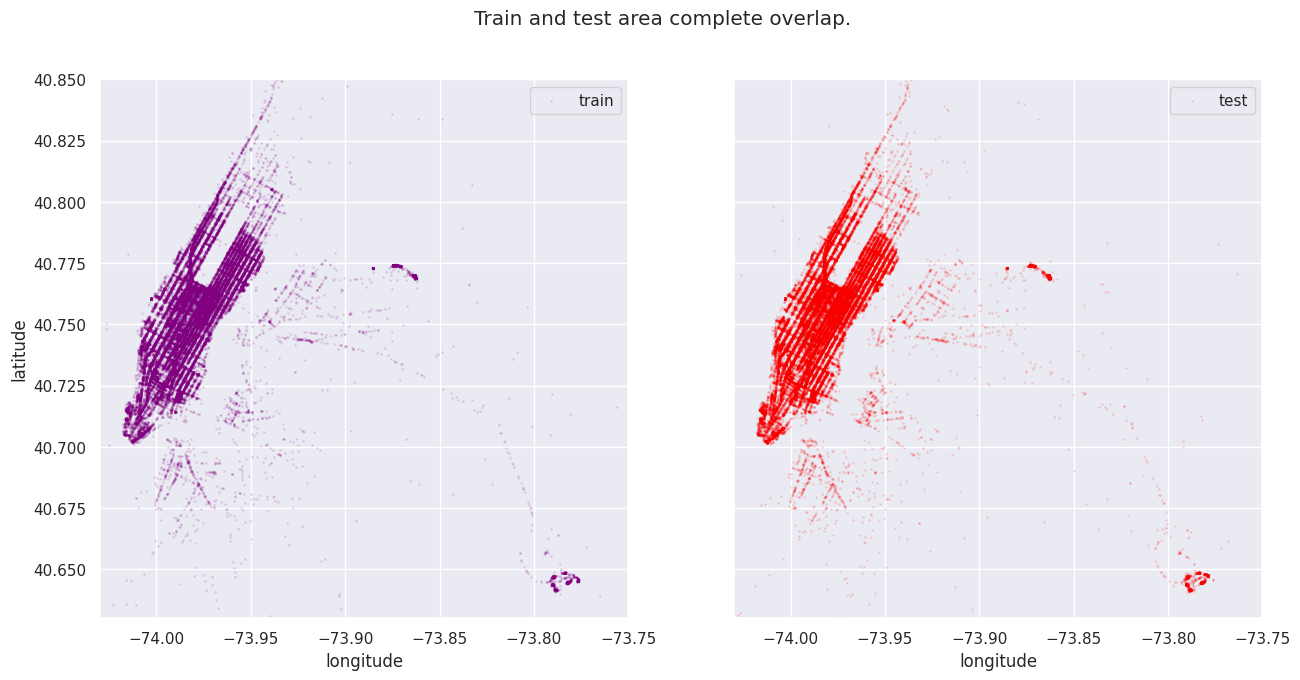

In [9]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True,figsize=(15,7))
ax[0].scatter(train['pickup_longitude'].values[:50000], train['pickup_latitude'].values[:50000],
              color='purple', s=1, label='train', alpha=0.1)

ax[1].scatter(test['pickup_longitude'].values[:50000], test['pickup_latitude'].values[:50000],
              color='red', s=1, label='test', alpha=0.1)


fig.suptitle('Train and test area complete overlap.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

We find that our train and test data sets do indeed cover the same time range and geographical area.

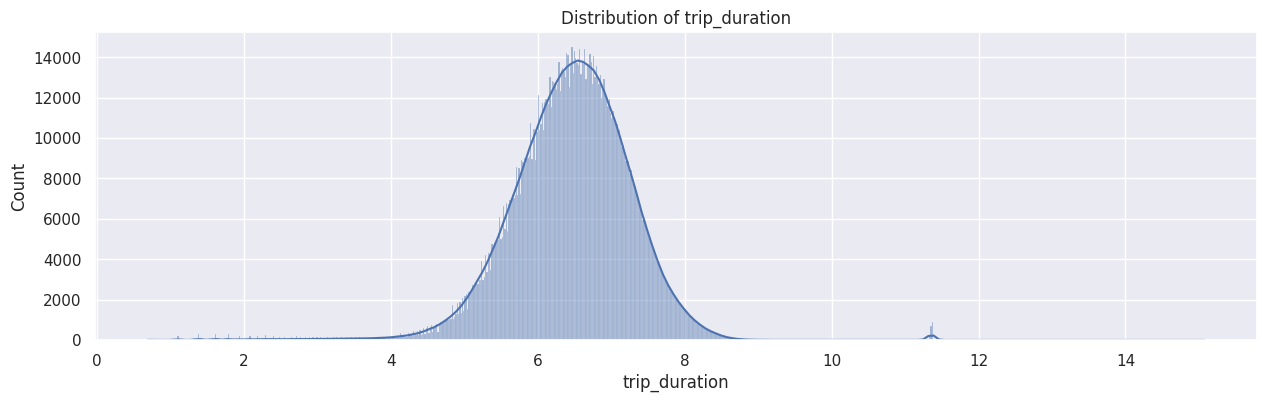

In [10]:
fig,ax = plt.subplots(1,1,figsize=(15,4))

hist1 = sns.histplot(data = train, x=np.log(1+train['trip_duration']),ax=ax,kde=True)
hist1.set(title='Distribution of trip_duration')
fig.show()

In [11]:
# converting trip duration into log-space
train.loc[:,'trip_duration'] = np.log(1+train.loc[:,'trip_duration'])
print('Converted trip_duration into log space:')

Converted trip_duration into log space:


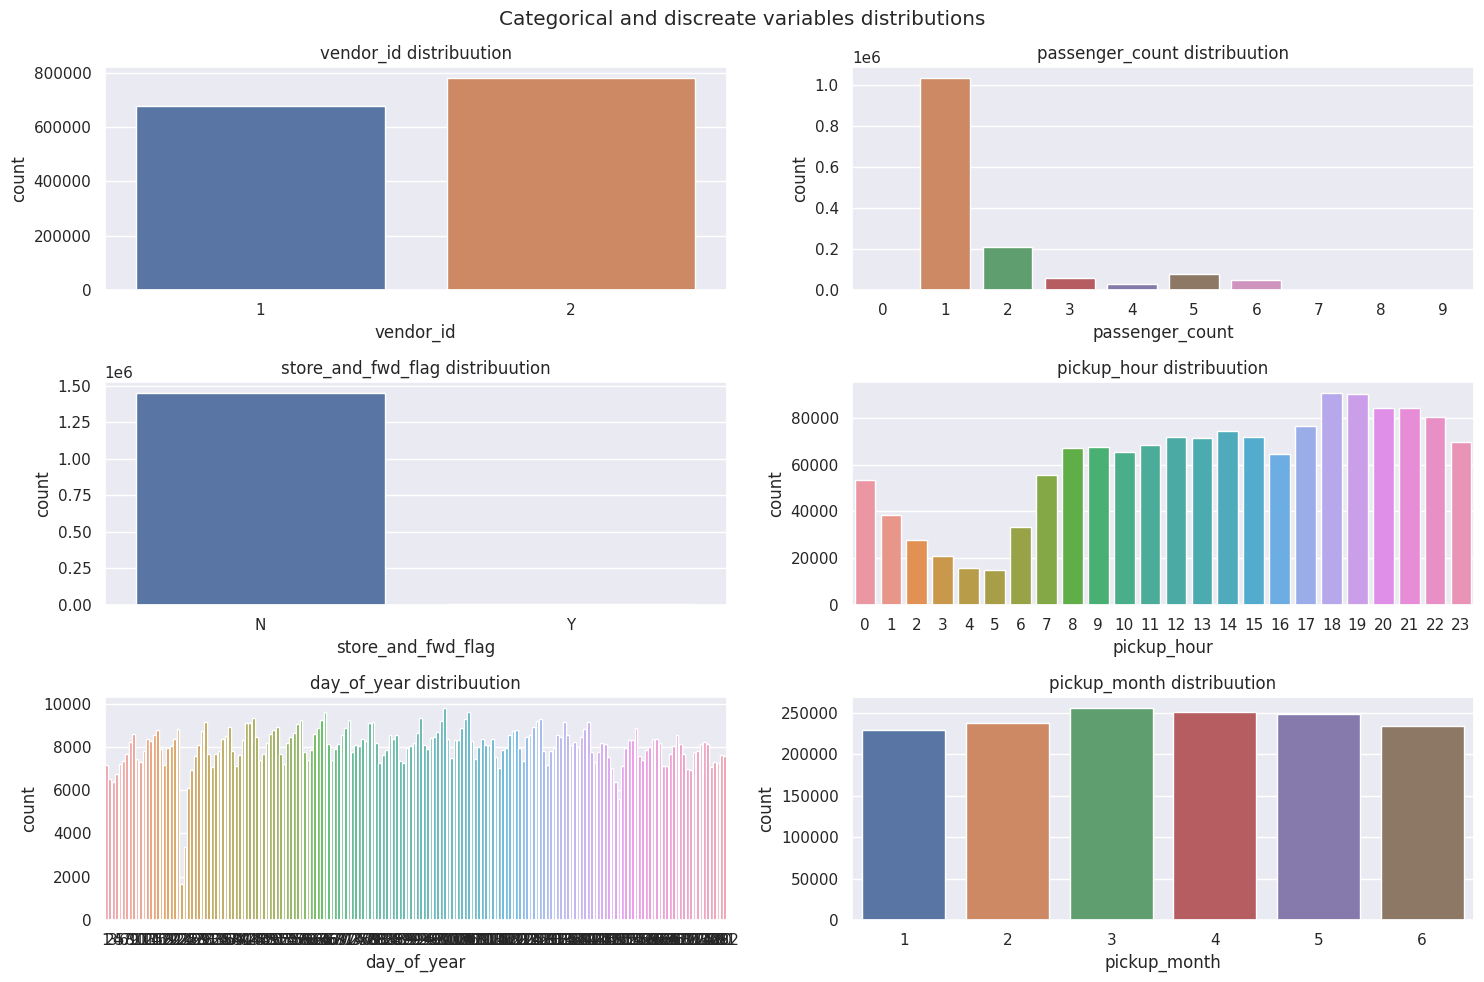

In [12]:
fig = plt.figure(figsize=(15,10))
for idx,col in enumerate(['vendor_id','passenger_count','store_and_fwd_flag','pickup_hour','day_of_year','pickup_month']):
    fig.add_subplot(3,2,idx+1)
    countplot = sns.countplot(data=train,x=col)
    countplot.set(title=f'{col} distribuution')
    
fig.suptitle('Categorical and discreate variables distributions')
fig.tight_layout()
fig.show()

1. Vendor 2 made more trips than vendor 1
2. Most trips were made with 1 passenger
3. There were mostly N=not a store and forward trip
4. After 12pm there was a dip in the number of rides till 5am . After that there was gradual increase till 4pm evening then again a gradual increase.
5. In day_of_year feature , we can see a sudden dip in trips around January. This can be due to weather condition.For this we'll include another dataset of weather.

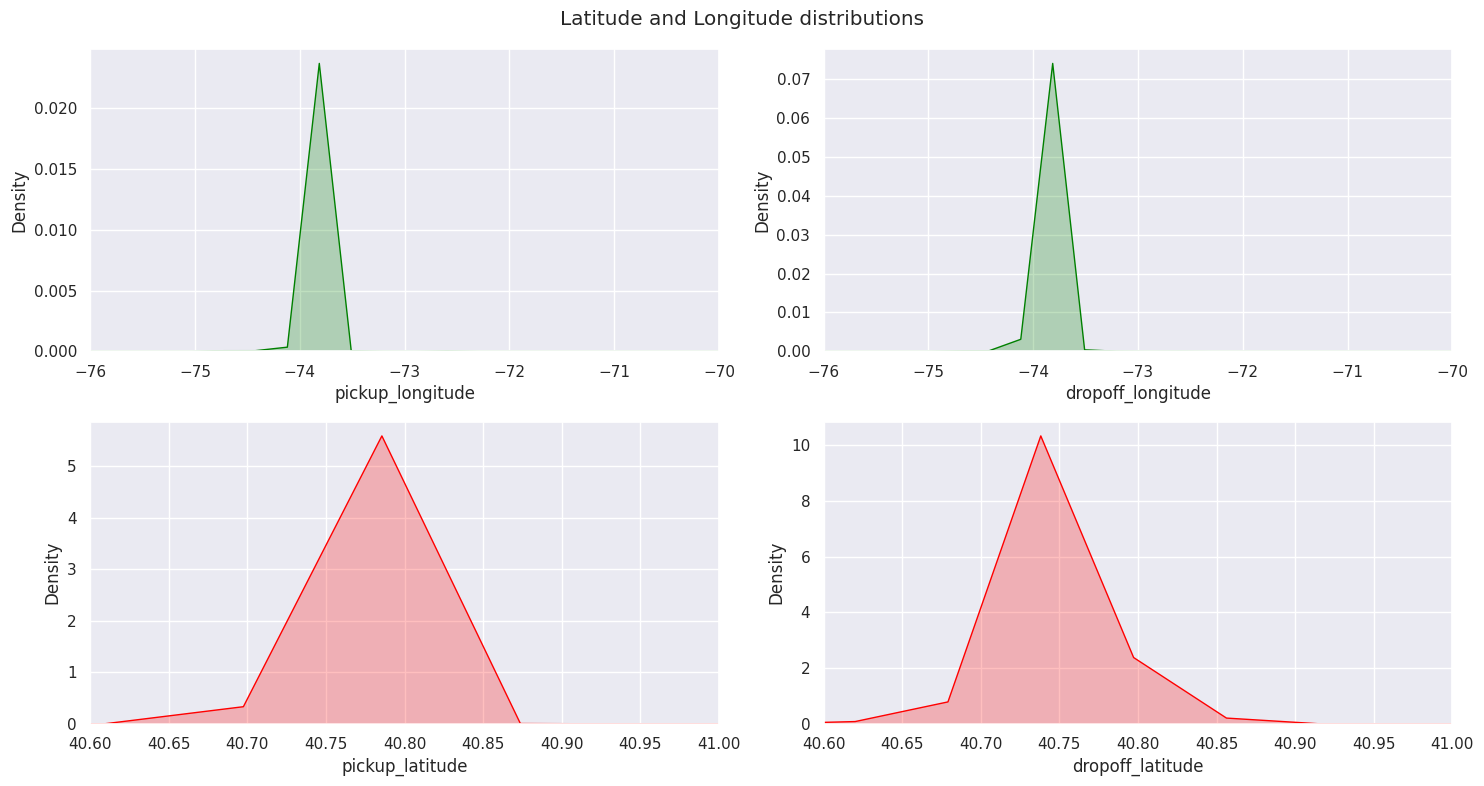

In [13]:
# restrincting the range of lat and long because very few cases are there when the trip is outside NYC and most trips were in Manhatten
fig,ax = plt.subplots(2,2,figsize=(15,8))

kde1 = sns.kdeplot(data=train,x='pickup_longitude',fill=True,color='green',ax=ax[0,0])
kde2 = sns.kdeplot(data=train,x='dropoff_longitude',fill=True,color='green',ax=ax[0,1])
ax[0,0].set_xlim([-76,-70])
ax[0,1].set_xlim([-76,-70])

kde3 = sns.kdeplot(data=train,x='pickup_latitude',fill=True,color='red',ax=ax[1,0])
kde4 = sns.kdeplot(data=train,x='dropoff_latitude',fill=True,color='red',ax=ax[1,1])
ax[1,0].set_xlim([40.6,41])
ax[1,1].set_xlim([40.6,41])

fig.suptitle('Latitude and Longitude distributions')
fig.tight_layout()
fig.show()

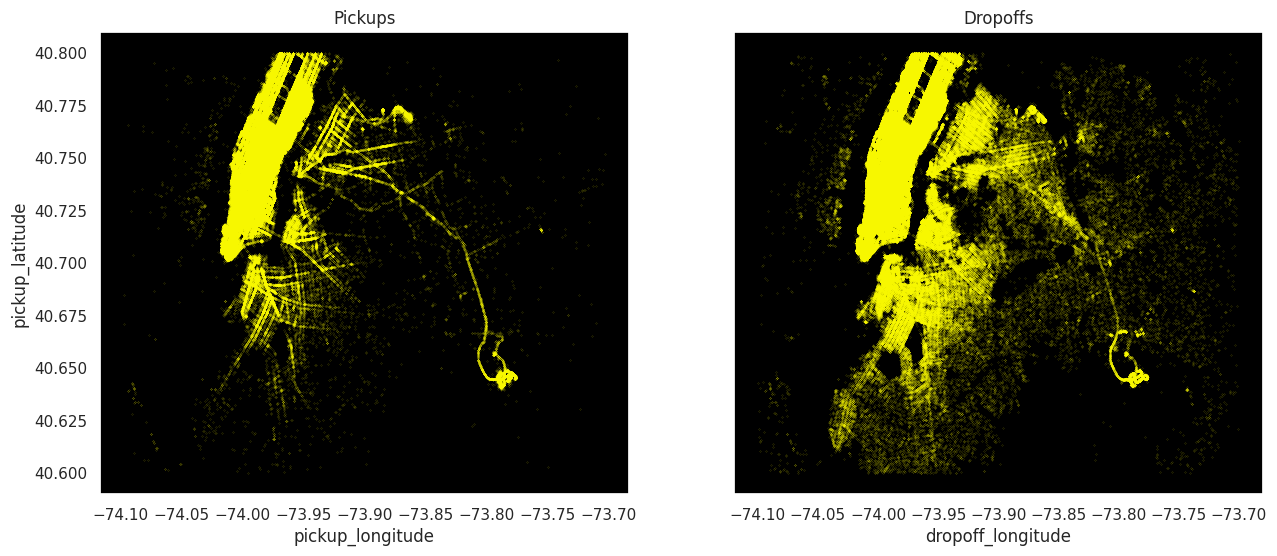

In [14]:
# train
train = train[(train['pickup_longitude'] > -74.1) & (train['pickup_longitude'] < -73.7)]
train = train[(train['pickup_latitude'] > 40.6) & (train['pickup_latitude']< 40.8)]
train = train[(train['dropoff_longitude'] > -74.1) & (train['dropoff_longitude'] < -73.7)]
train = train[(train['dropoff_latitude'] > 40.6) & (train['dropoff_latitude']< 40.8)]

# test
test = test[(test['pickup_longitude'] > -74.1) & (test['pickup_longitude'] < -73.7)]
test = test[(test['pickup_latitude'] > 40.6) & (test['pickup_latitude']< 40.8)]
test = test[(test['dropoff_longitude'] > -74.1) & (test['dropoff_longitude'] < -73.7)]
test = test[(test['dropoff_latitude'] > 40.6) & (test['dropoff_latitude']< 40.8)]

f, (ax1, ax2) = plt.subplots(1, 2,sharey=True,figsize=(15,6))
train.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude',
                color='yellow', 
                s=.02, alpha=.6, subplots=True, ax=ax1)
ax1.set_title("Pickups")
ax1.set_facecolor('black')
ax1.grid(False)

train.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude',
                color='yellow',
                s=.02, alpha=.6, subplots=True, ax=ax2)
ax2.set_title("Dropoffs")
ax2.set_facecolor('black')
ax2.grid(False)

In [15]:
# We use PCA to transform longitude and latitude coordinates. The rotation could help for decision tree splits.
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))

pca = PCA().fit(coords)
train['pickup_pca0'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 0]
train['pickup_pca1'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 1]
train['dropoff_pca0'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
train['dropoff_pca1'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
test['pickup_pca0'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 0]
test['pickup_pca1'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 1]
test['dropoff_pca0'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
test['dropoff_pca1'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has fe

### Feature relations - How features are related to each other and with target feature i.e. trip_duration

#### vendor_id and pickup_date/dropoff_date VS trip_duration

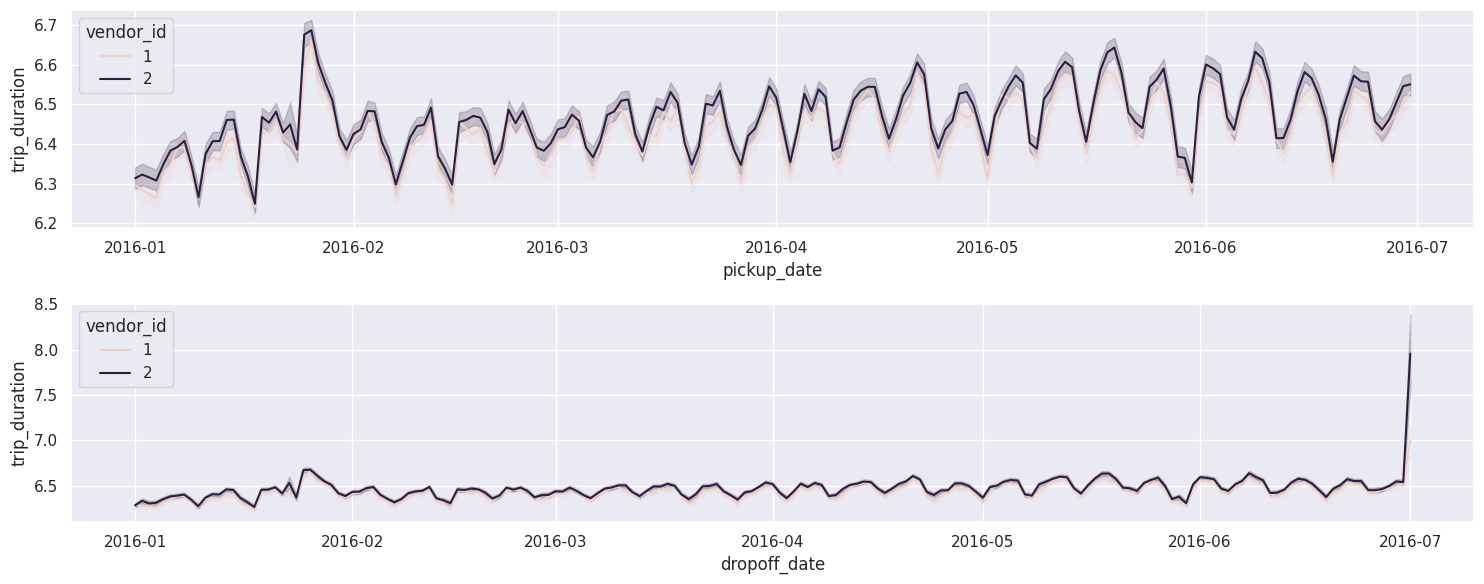

In [16]:
#pickup and dropoff trips made by each vendors on each date
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(15,6))

sns.lineplot(data=train,x='pickup_date',y='trip_duration',hue='vendor_id',ax=ax1)
sns.lineplot(data=train,x='dropoff_date',y='trip_duration',hue='vendor_id',ax=ax2)
fig.tight_layout()
fig.show()

#### vendor_id and weekday/pickup_hour VS trip_duration

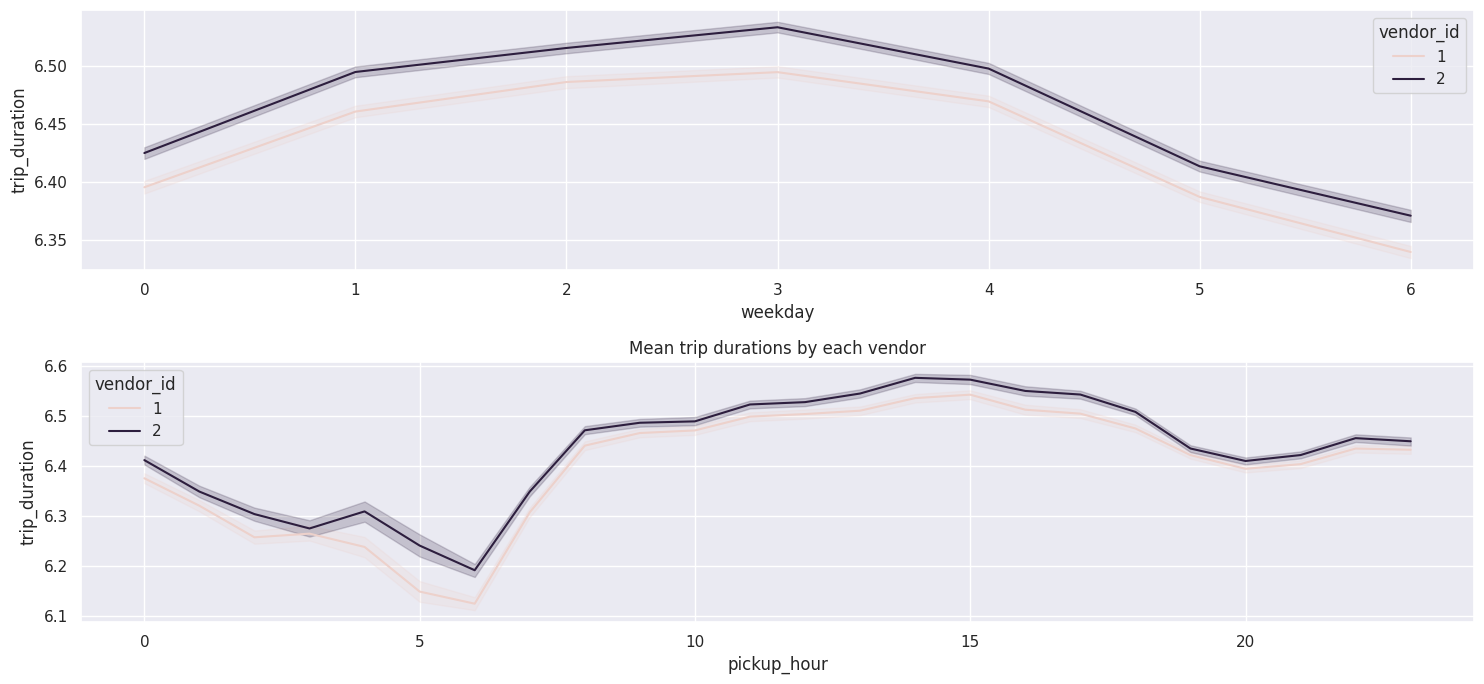

In [17]:
fig,ax = plt.subplots(2,1,figsize=(15,7))

sns.lineplot(data=train, x='weekday',y='trip_duration',hue='vendor_id',ax=ax[0])
sns.lineplot(data=train, x='pickup_hour',y='trip_duration',hue='vendor_id',ax=ax[1])
plt.title('Mean trip durations by each vendor')
fig.tight_layout()
fig.show()

1. Vendor 2 has more average trips than vendor 1 on all weekdays. The trend is same for months. Vendor id seems to be a important feature to include in the model.
2. As seen earlier, there is a sudden dip at early morning around 5am and a gradual decrease around 8pm.
3. On Sunday, the average trip duration was around 16min. for vendor 2 and 14min. for vendor 1
4. We decide to include weekday and pickup_hour in our model.

#### passenger_count and vendor_id VS trip_duration

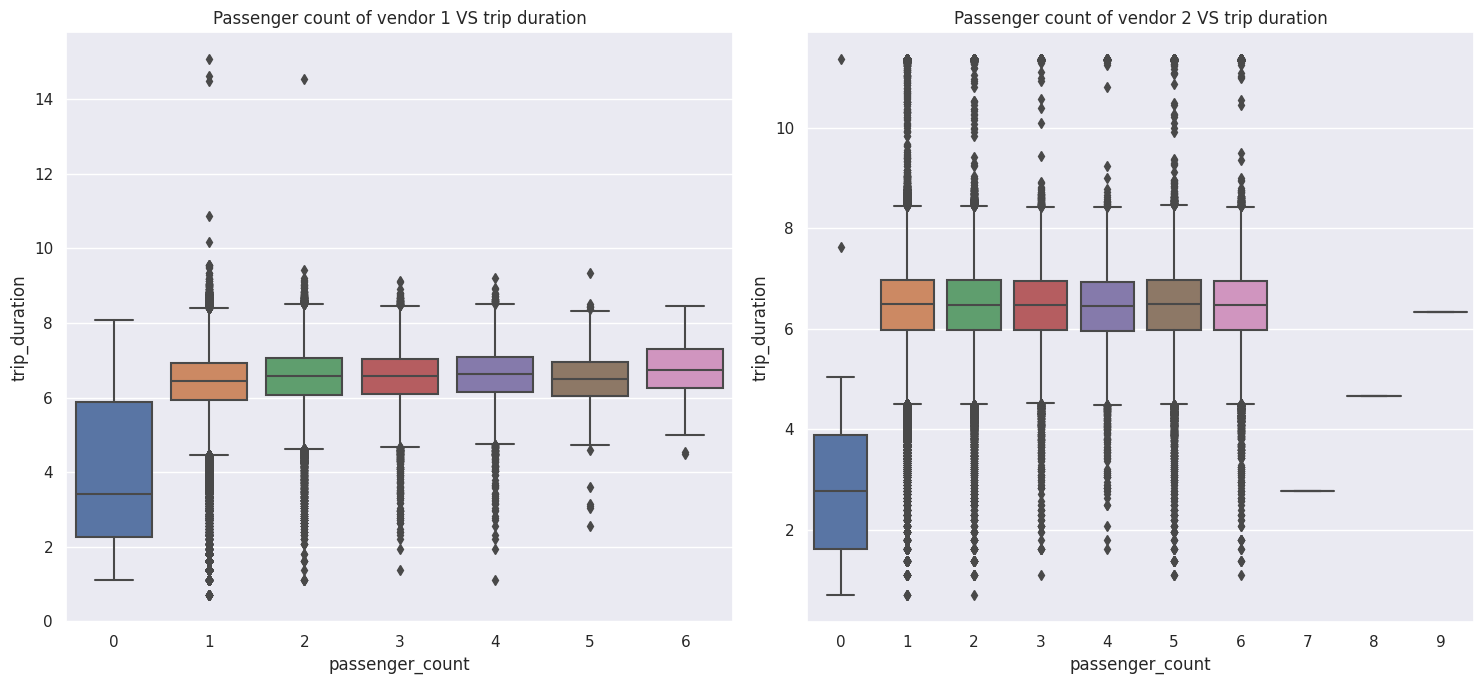

In [18]:
fig ,ax = plt.subplots(1,2,figsize=(15,7))

box1 = sns.boxplot(data=train[train['vendor_id']==1].reset_index(), x='passenger_count', y='trip_duration',ax=ax[0])
box2 = sns.boxplot(data=train[train['vendor_id']==2].reset_index(), x='passenger_count', y='trip_duration',ax=ax[1])
box1.set(title='Passenger count of vendor 1 VS trip duration')
box2.set(title='Passenger count of vendor 2 VS trip duration')
fig.tight_layout()
fig.show()

1. With passenger = 0, the trip duration was at max minimum 2.5 min. and maximum 20 min.These are outliers and should be removed.
2. Some trips has very short duration ~ 0.5 min. with both vendors.
3. When passenger count 2 and 5, vendor 2 has some trips around ~ 340hrs.
4. Vendor 1 only carried atmost 6 passengers at a time. Very less trips are there when passenger count is 7,8,9 with vendor 2.

In [19]:
print('Rows before train:',train.shape[0])
print('Rows before test:',test.shape[0])
train = train[~(train['passenger_count'] == 0)]
test = test[~(test['passenger_count'] == 0)]
print('Rows after train:',train.shape[0])
print('Rows after train:',test.shape[0])

Rows before train: 1373668
Rows before test: 589311
Rows after train: 1373616
Rows after train: 589293


#### vendor_id VS trip_duration

Trip duration stats for vendor 1: 
mean    833.073639
50%     648.000000
Name: trip_duration, dtype: float64

Trip duration stats for vendor 2: 
mean    1041.284343
50%      656.000000
Name: trip_duration, dtype: float64


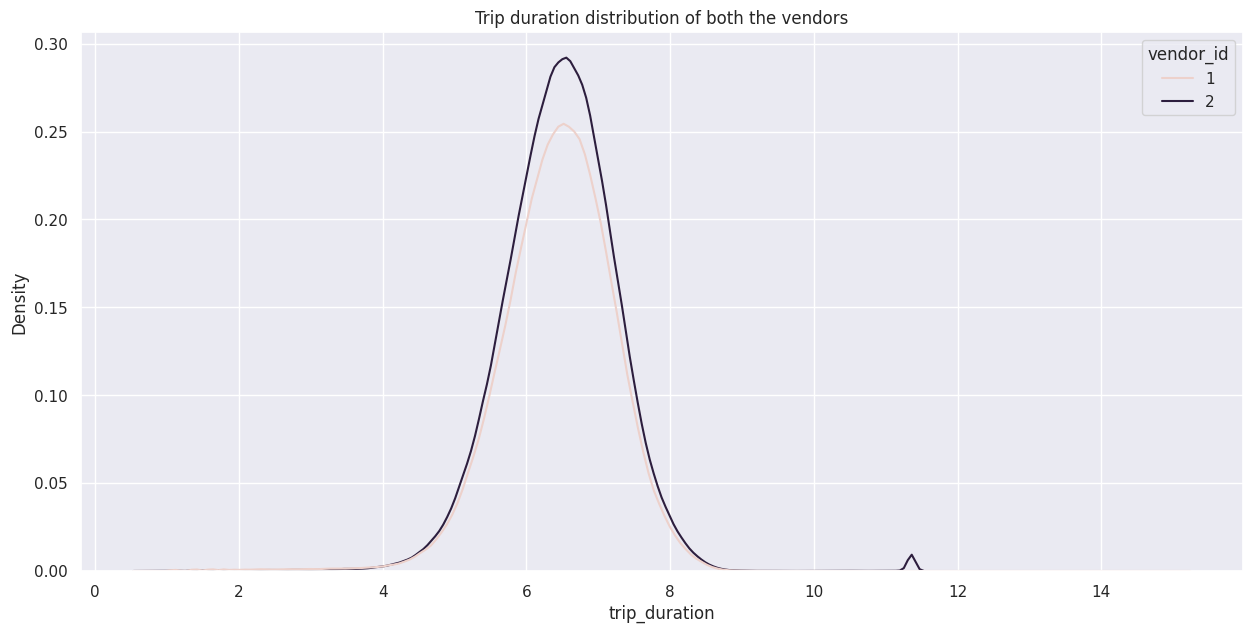

In [20]:
print('Trip duration stats for vendor 1: ')
vendor1_trip = train[train['vendor_id']==1]['trip_duration']
print(np.exp(vendor1_trip).describe()[['mean','50%']])
print()
print('Trip duration stats for vendor 2: ')
vendor2_trip = train[train['vendor_id']==2]['trip_duration']
print(np.exp(vendor2_trip).describe()[['mean','50%']])

fig = plt.figure(figsize=(15,7))
sns.kdeplot(data=train, x='trip_duration',hue='vendor_id')
plt.title('Trip duration distribution of both the vendors')
fig.show()

1. Median trip duration by both vendors are very similar whereas there is a difference in mean trip duration because of some larger duration trips done by vendor 2

#### store_and_fwd_flag and passenger_count VS trip_duration

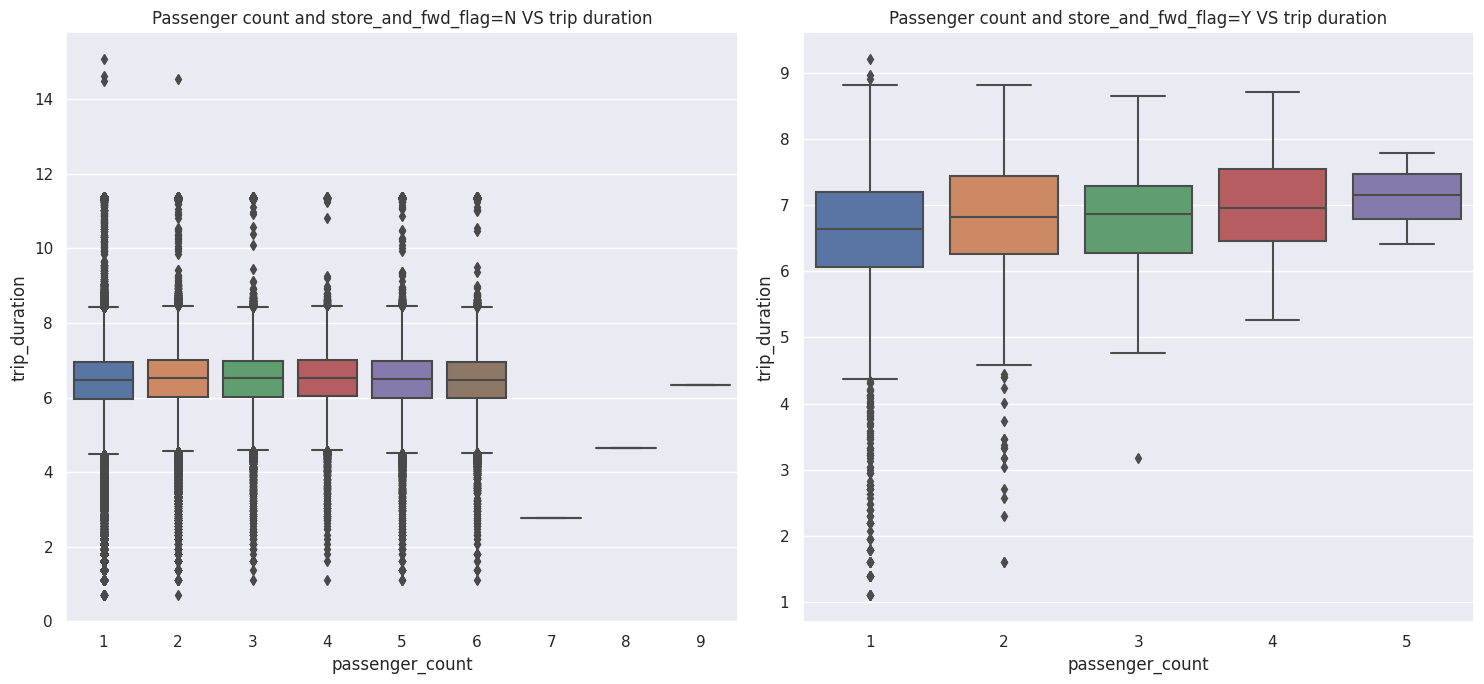

In [21]:
fig ,ax = plt.subplots(1,2,figsize=(15,7))

box1 = sns.boxplot(data=train[train['store_and_fwd_flag']=='N'].reset_index(), x='passenger_count', y='trip_duration',ax=ax[0])
box2 = sns.boxplot(data=train[train['store_and_fwd_flag']=='Y'].reset_index(), x='passenger_count', y='trip_duration',ax=ax[1])
box1.set(title='Passenger count and store_and_fwd_flag=N VS trip duration')
box2.set(title='Passenger count and store_and_fwd_flag=Y VS trip duration')
fig.tight_layout()
fig.show()

Some trips which are stored are longer than the ones which are stored.

/tmp/ipykernel_32/4099351181.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[:,'pickup_cluster'] =  kmeans_pickup.predict(train.loc[:,['pickup_longitude','pickup_latitude']])
/tmp/ipykernel_32/4099351181.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[:,'dropoff_cluster'] =  kmeans_drop.predict(train.loc[:,['dropoff_longitude','dropoff_latitude']])


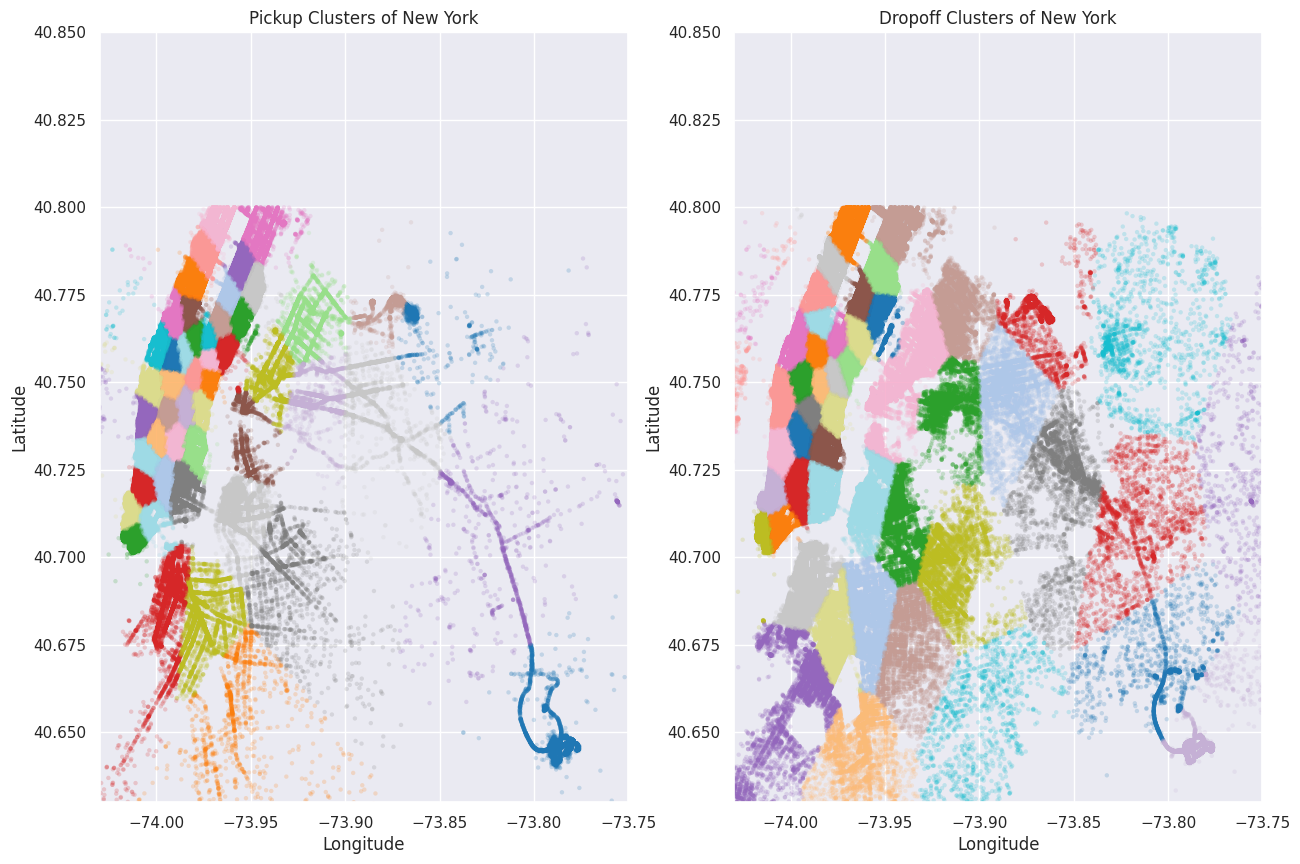

In [22]:
kmeans_pickup = MiniBatchKMeans(n_clusters=50, random_state=2, batch_size=10000 ,n_init = 10).fit(train[['pickup_longitude','pickup_latitude']])
kmeans_drop = MiniBatchKMeans(n_clusters=50, random_state=2, batch_size=10000 ,n_init = 10).fit(train[['dropoff_longitude','dropoff_latitude']])

# train
train.loc[:,'pickup_cluster'] =  kmeans_pickup.predict(train.loc[:,['pickup_longitude','pickup_latitude']])
train.loc[:,'dropoff_cluster'] =  kmeans_drop.predict(train.loc[:,['dropoff_longitude','dropoff_latitude']])

# test
test.loc[:,'pickup_cluster'] =  kmeans_pickup.predict(test.loc[:,['pickup_longitude','pickup_latitude']])
test.loc[:,'dropoff_cluster'] =  kmeans_drop.predict(test.loc[:,['dropoff_longitude','dropoff_latitude']])


city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

fig, ax = plt.subplots(ncols=2, nrows=1,figsize=(15,10))
ax[0].scatter(train.pickup_longitude.values, 
           train.pickup_latitude.values, s=10, lw=0,
           c=train.pickup_cluster.values, 
           cmap='tab20', 
           alpha=0.2)
ax[1].scatter(train.dropoff_longitude.values, 
           train.dropoff_latitude.values, s=10, lw=0,
           c=train.dropoff_cluster.values, 
           cmap='tab20', 
           alpha=0.2)

ax[0].set_xlim(city_long_border)
ax[0].set_ylim(city_lat_border)
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')

ax[1].set_xlim(city_long_border)
ax[1].set_ylim(city_lat_border)
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')

ax[0].set_title('Pickup Clusters of New York')
ax[1].set_title('Dropoff Clusters of New York')
plt.show()

In [23]:
centroid_pickups = pd.DataFrame(kmeans_pickup.cluster_centers_, columns = ['centroid_pick_long', 'centroid_pick_lat'])
centroid_dropoff = pd.DataFrame(kmeans_drop.cluster_centers_, columns = ['centroid_drop_long', 'centroid_drop_lat'])

# assign names to each cluster like 1,2,3,etc.
centroid_pickups['pickup_cluster'] = centroid_pickups.index
centroid_dropoff['dropoff_cluster'] = centroid_dropoff.index

# train
train = pd.merge(train, centroid_pickups, how='left', on=['pickup_cluster'])
train = pd.merge(train, centroid_dropoff, how='left', on=['dropoff_cluster'])

# test
test = pd.merge(test, centroid_pickups, how='left', on=['pickup_cluster'])
test = pd.merge(test, centroid_dropoff, how='left', on=['dropoff_cluster'])

In [24]:
def cluster_map(df):
    
    m = folium.Map(location=[40.767937, -73.982155], zoom_start=12)
    for i in df.index:

        pick_long = centroid_pickups.iloc[i]['centroid_pick_long']
        pick_lat = centroid_pickups.iloc[i]['centroid_pick_lat']
        cluster_no = centroid_pickups.iloc[i]['pickup_cluster']
        
        pop = 'cluster no = '+str(cluster_no)

        folium.CircleMarker(location=[pick_lat,pick_long], radius=20,color='red',fill_color='#3186cc').add_to(m)
        folium.Marker(location=[pick_lat,pick_long],tooltip=pop).add_to(m)
    return m

m = cluster_map(centroid_pickups)
m

In [25]:
def haversine_(lat1, lng1, lat2, lng2):
    """function to calculate haversine distance between two co-ordinates"""
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return(h)


def bearing_array(lat1, lng1, lat2, lng2):
    """ Calculates the angle or direction of 2 points with consideration of the roundness of earth."""
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

# train
train.loc[:, 'distance_haversine'] = haversine_(train.loc[:,'pickup_latitude'].values, train.loc[:,'pickup_longitude'].values,
                                                train.loc[:,'dropoff_latitude'].values, train.loc[:,'dropoff_longitude'].values)

train.loc[:, 'direction'] = bearing_array(train.loc[:,'pickup_latitude'].values, train.loc[:,'pickup_longitude'].values,
                                          train.loc[:,'dropoff_latitude'].values, train.loc[:,'dropoff_longitude'].values)

train.loc[:, 'center_latitude'] = (train.loc[:,'pickup_latitude'].values + train.loc[:,'dropoff_latitude'].values) / 2
train.loc[:, 'center_longitude'] = (train.loc[:,'pickup_longitude'].values + train.loc[:,'dropoff_longitude'].values) / 2

train.loc[:,'avg_speed_hvsn'] = 1000 * train.loc[:,'distance_haversine'] / np.exp(train.loc[:,'trip_duration'])

# test
test.loc[:, 'distance_haversine'] = haversine_(test.loc[:,'pickup_latitude'].values, test.loc[:,'pickup_longitude'].values,
                                                test.loc[:,'dropoff_latitude'].values, test.loc[:,'dropoff_longitude'].values)

test.loc[:, 'direction'] = bearing_array(test.loc[:,'pickup_latitude'].values, test.loc[:,'pickup_longitude'].values,
                                          test.loc[:,'dropoff_latitude'].values, test.loc[:,'dropoff_longitude'].values)

test.loc[:, 'center_latitude'] = (test.loc[:,'pickup_latitude'].values + test.loc[:,'dropoff_latitude'].values) / 2
test.loc[:, 'center_longitude'] = (test.loc[:,'pickup_longitude'].values + test.loc[:,'dropoff_longitude'].values) / 2

#### havsine distance VS trip_duration

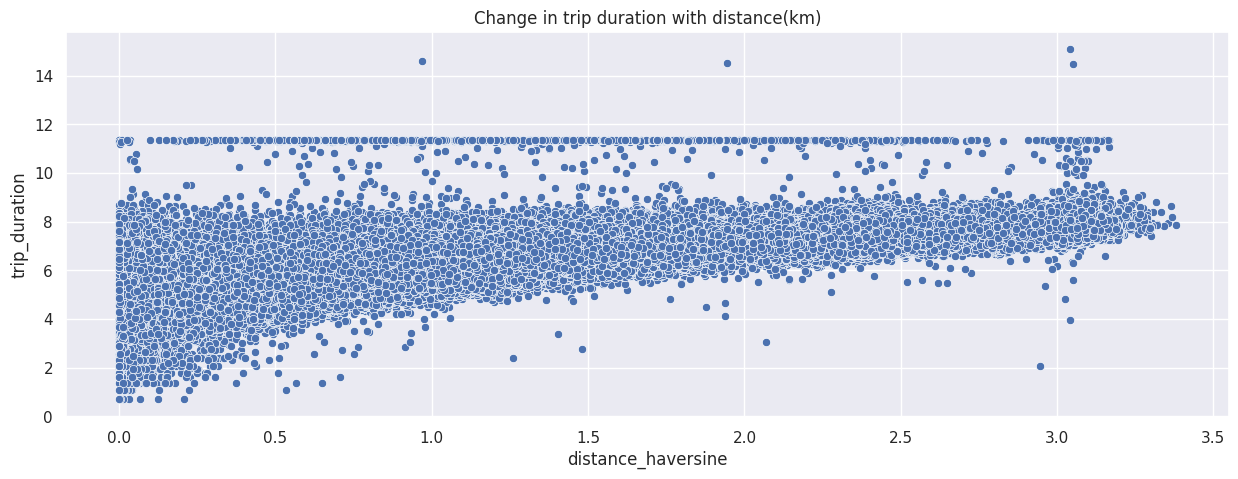

In [26]:
plt.figure(figsize=(15,5))
sns.scatterplot(data = train, x= np.log(1+train['distance_haversine']),y='trip_duration')
plt.title('Change in trip duration with distance(km)')
plt.show()

1. We can see that with an increase distance(km) , trip duration is also increasing
2. There are some trips with very short distance < 1 km but very high trip duration > 50min. We should remove such extreme and suspecious points

In [27]:
# train
train.loc[:,'distance_haversine'] = np.log(1+train.loc[:,'distance_haversine'])
train.loc[:,'avg_speed_hvsn'] = np.log(1+train.loc[:,'avg_speed_hvsn'])

# test
test.loc[:,'distance_haversine'] = np.log(1+test.loc[:,'distance_haversine'])

In [28]:
print('Total rows before train:', train.shape[0])
print('Total rows before test:', test.shape[0])

train = train[(train['trip_duration'] > 3) & (train['trip_duration'] < 10)]
train = train[~(train['distance_haversine'] > 5)]
train = train[~((train['distance_haversine'] > 6) & (train['trip_duration'] < 6))]

test = test[~(test['distance_haversine'] > 5)]

print('Total rows after train:', train.shape[0])
print('Total rows after test:', test.shape[0])

Total rows before train: 1373616
Total rows before test: 589293
Total rows after train: 1368539
Total rows after test: 589293


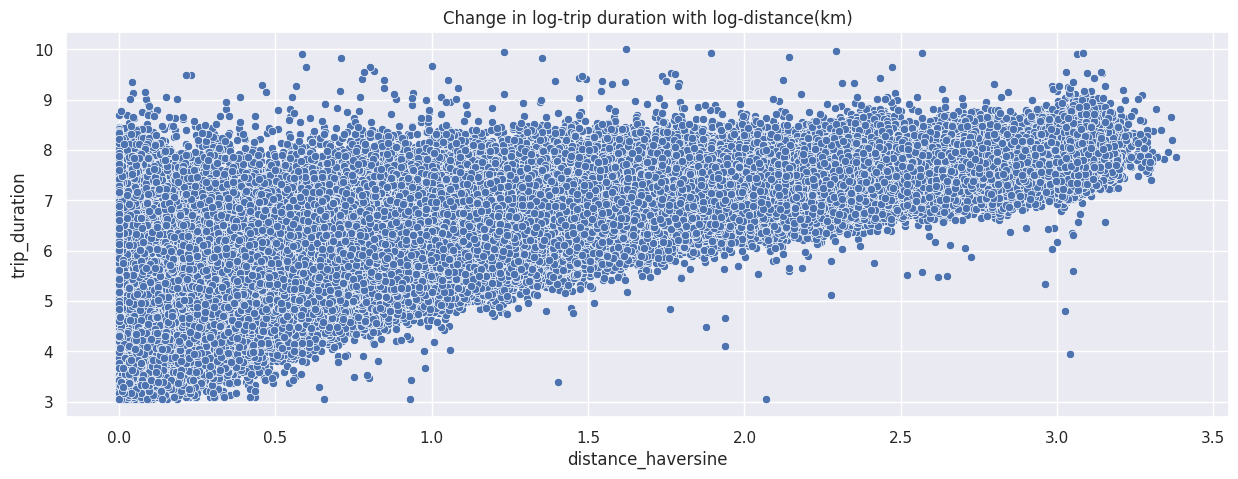

In [29]:
plt.figure(figsize=(15,5))
sns.scatterplot(data = train, x='distance_haversine',y='trip_duration')
plt.title('Change in log-trip duration with log-distance(km)')
plt.show()

Text(0.5, 1.0, 'Average log-speed distribution')

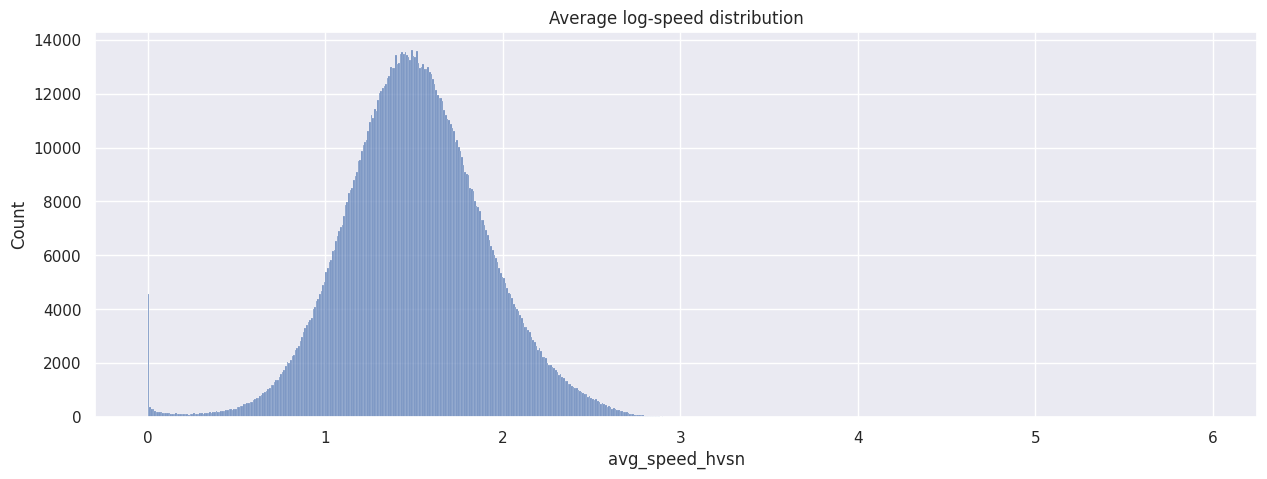

In [30]:
fig = plt.figure(figsize=(15,5))
sns.histplot(data=train, x='avg_speed_hvsn')
plt.title('Average log-speed distribution')

Text(0.5, 1.0, 'Log-Average speed on each day')

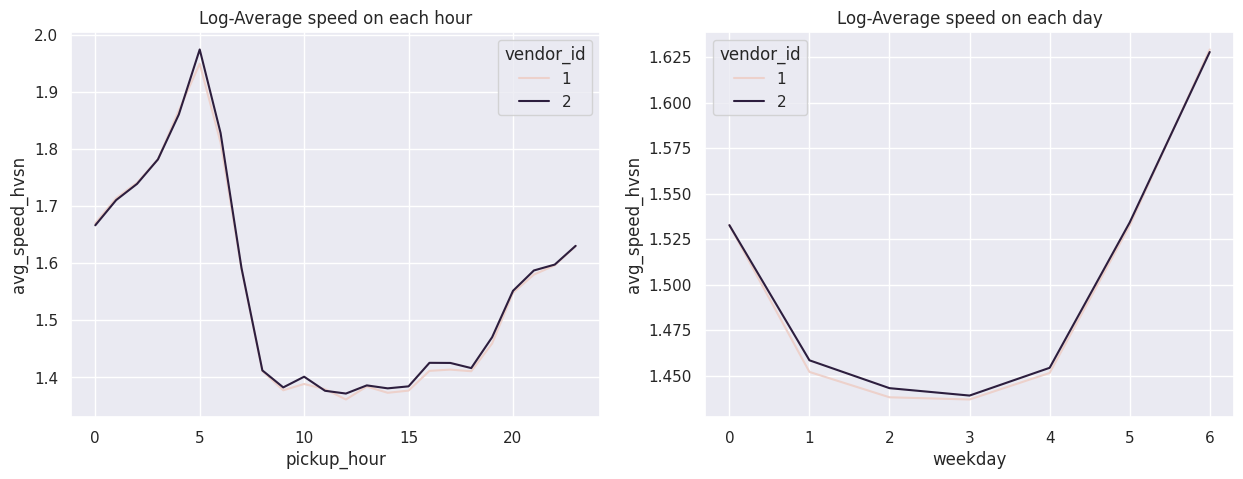

In [31]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
avg_speed_every_hour = train.groupby(['pickup_hour','vendor_id'])['avg_speed_hvsn'].median().reset_index()
avg_speed_every_day = train.groupby(['weekday','vendor_id'])['avg_speed_hvsn'].median().reset_index()
sns.lineplot(data = avg_speed_every_hour ,x = 'pickup_hour' , y='avg_speed_hvsn',hue='vendor_id',ax=ax[0])
sns.lineplot(data = avg_speed_every_day ,x = 'weekday' , y='avg_speed_hvsn',hue='vendor_id',ax=ax[1])
ax[0].set_title('Log-Average speed on each hour')
ax[1].set_title('Log-Average speed on each day')

1. Taxi travelling faster on weekends than any other day
2. During the work hours the speed is slow
3. We should make a new feature 'work' which denotes 8-6 pm on Mon to Friday

In [32]:
weather = pd.read_csv('/kaggle/input/weather-data-in-new-york-city-2016/weather_data_nyc_centralpark_2016(1).csv')
weather['date'] = pd.to_datetime(weather['date'],dayfirst=False,format='mixed')
weather.head()

,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth
0,2016-01-01,42,34,38.0,0.00,0.0,0
1,2016-02-01,40,32,36.0,0.00,0.0,0
2,2016-03-01,45,35,40.0,0.00,0.0,0
3,2016-04-01,36,14,25.0,0.00,0.0,0
4,2016-05-01,29,11,20.0,0.00,0.0,0


In [33]:
weather['precipitation'] = weather['precipitation'].str.replace('T','0.01').astype(float)
weather['snow fall'] = weather['snow fall'].str.replace('T','0.01').astype(float)
weather['snow depth'] = weather['snow depth'].str.replace('T','0.01').astype(float)

In [34]:
train = pd.merge(train,weather,on='date')
test = pd.merge(test,weather,on='date')
print('Train shape:',train.shape)
print('Test shape:',test.shape)

Train shape: (1368539, 39)
Test shape: (589293, 35)


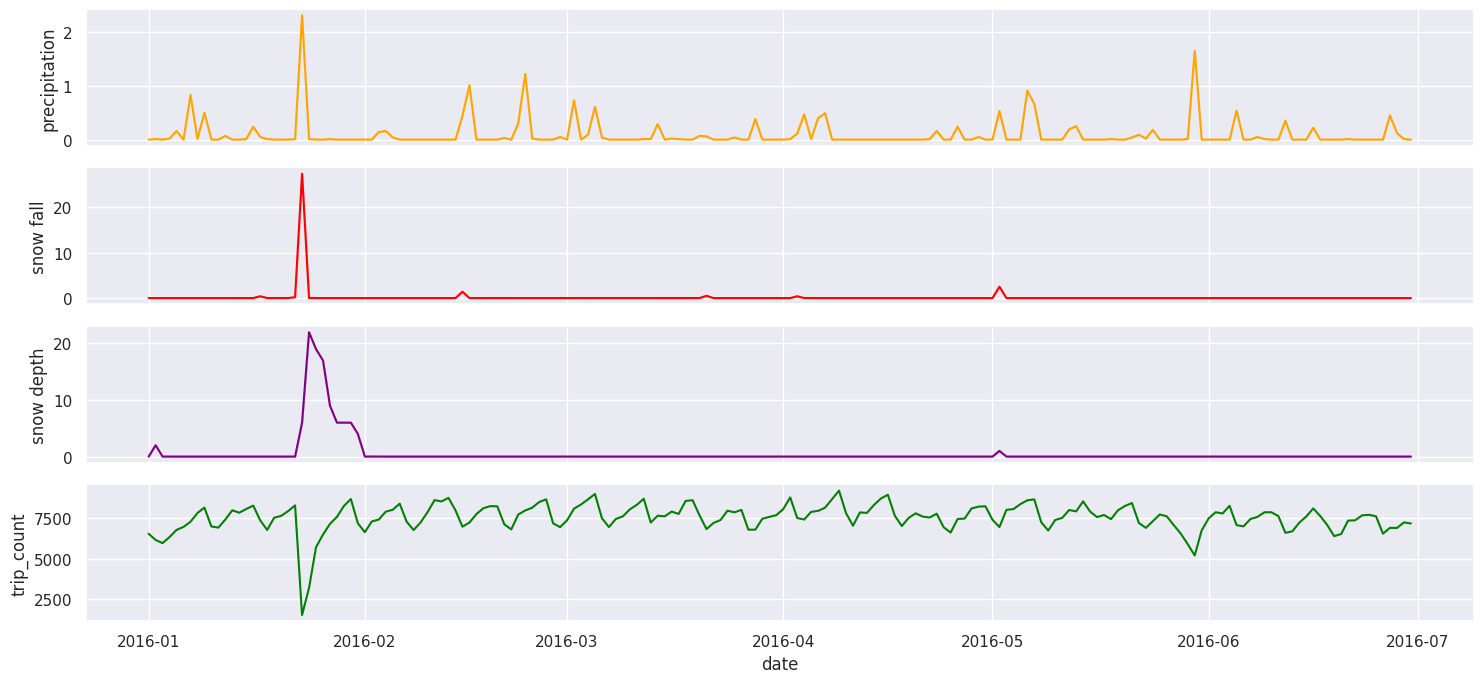

In [35]:
fig , ax = plt.subplots(4,1,figsize=(15,7),sharex=True)
# avg_speed_dates = total2.groupby(['date'])['avg_speed_hvsn'].median().reset_index()
trips_per_day = pd.DataFrame(train.groupby(['date'])['date'].count()).rename(columns={'date':'trip_count'}).reset_index()
sns.lineplot(data=train, x='date',y='precipitation',ax=ax[0],color='orange')
sns.lineplot(data=train, x='date',y='snow fall',ax=ax[1],color='red')
sns.lineplot(data=train, x='date',y='snow depth',ax=ax[2],color='purple')
sns.lineplot(data=trips_per_day, x='date',y='trip_count',ax=ax[3],color='green')

fig.tight_layout()

We can see a spike between the month of January and Feburary of 2016 for high snowfall and precipitation and strong dip in passenger count at the same time which is indeed true.More can be read from [here](https://www.weather.gov/okx/Blizzard_Jan2016) 

In [36]:
# convert to numerical
train.store_and_fwd_flag = (train.store_and_fwd_flag=='Y').astype(int)
test.store_and_fwd_flag = (test.store_and_fwd_flag=='Y').astype(int)

/tmp/ipykernel_32/2523441426.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<Axes: >

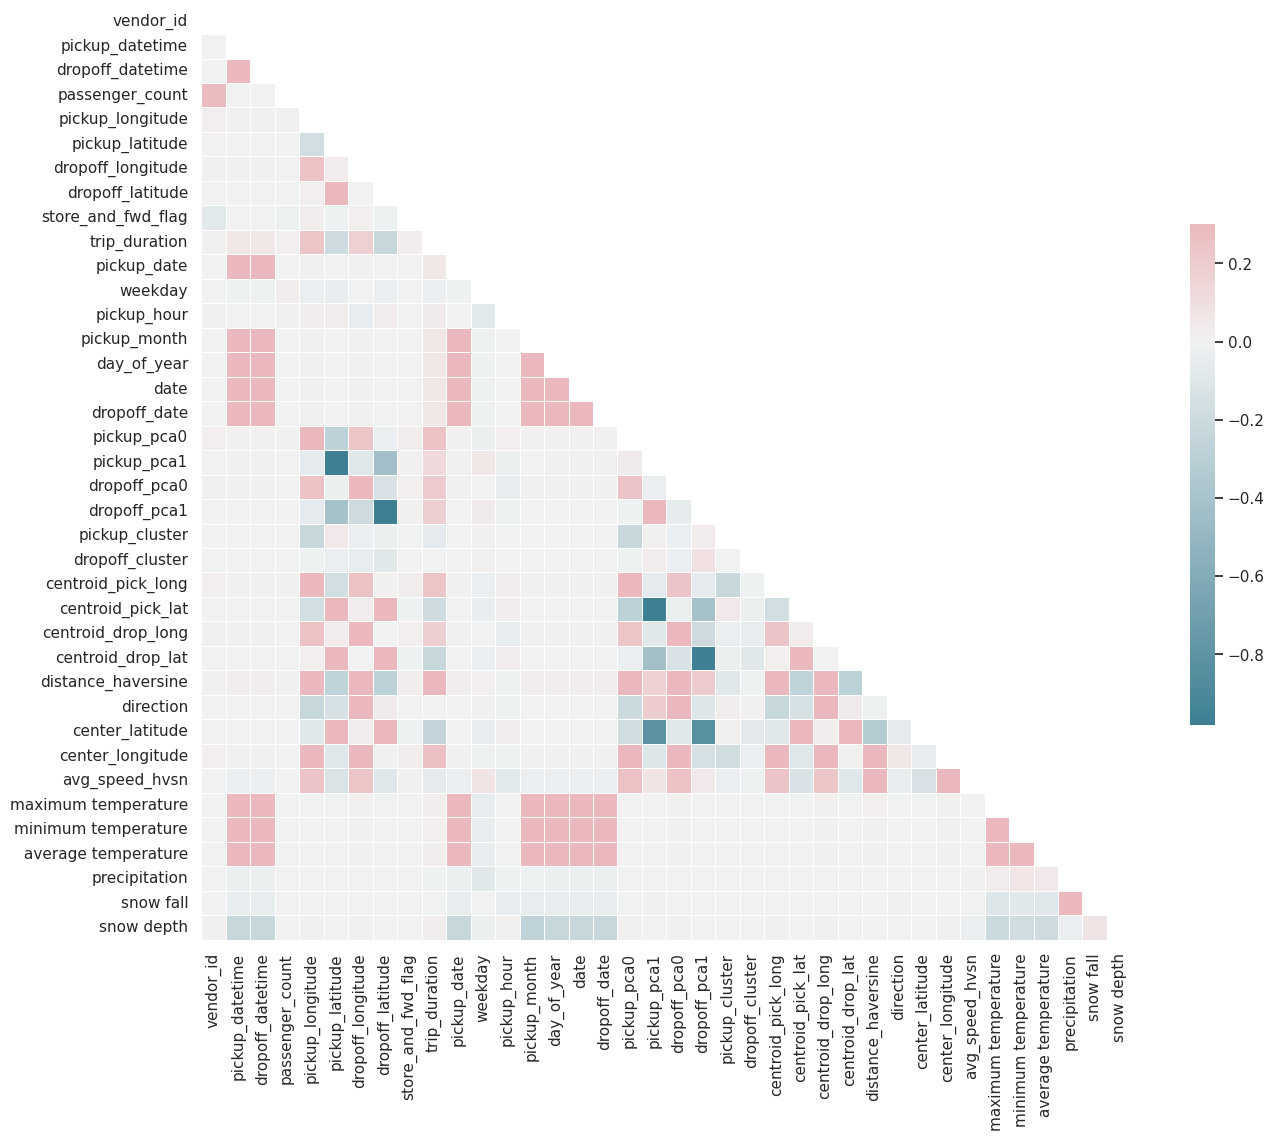

In [37]:
sns.set(style="white")

# Generate a large random dataset
temp3 = train.copy()
temp3.drop(['id'],axis=1,inplace=True)

# Compute the correlation matrix
corr = temp3.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 13))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [38]:
y = train['trip_duration']
train_id = train['id']
test_id = test['id']
train = train.drop(['id', 'pickup_datetime','dropoff_datetime','trip_duration', 'pickup_date','dropoff_date','date','avg_speed_hvsn'],axis=1)
test = test.drop(['id', 'pickup_datetime', 'pickup_date','date',],axis=1)
print(train.shape,test.shape)

(1368539, 31) (589293, 31)


In [39]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
y = y.reset_index(drop=True)
# train-test split
X_train, X_val, y_train, y_val = train_test_split(train,y,test_size=0.2,random_state=2)
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)

(1094831, 31) (1094831,)
(273708, 31) (273708,)


In [40]:
regressors = {
    "LGBM1" : LGBMRegressor(random_state=2),
    "LGBM2" : LGBMRegressor(random_state=2)
}

## Grids for randomized search
lgbm_grid1 = {
        'n_estimators': np.arange(100, 1000, 100),
        'learning_rate': np.arange(0.01, 0.3, 0.01),
        'max_depth': np.arange(3, 11),
        'subsample': np.arange(0.6, 1.0, 0.05),
        'colsample_bytree': np.arange(0.6, 1.0, 0.05),
        'reg_alpha': np.arange(0.0, 1.0, 0.1),
        'reg_lambda': np.arange(0.0, 1.0, 0.1),
        }

lgbm_grid2 = {
        'n_estimators': np.arange(100, 1000, 200),
        'learning_rate': np.arange(0.01, 0.3, 0.05),
        'max_depth': np.arange(3, 11),
        'subsample': np.arange(0.6, 1.0, 0.1),
        'colsample_bytree': np.arange(0.6, 1.0, 0.1),
        'reg_alpha': np.arange(0.0, 1.0, 0.2),
        'reg_lambda': np.arange(0.0, 1.0, 0.2),
}


# # Dictionary of all grids
grid = {
    "LGBM1" : lgbm_grid1,
    "LGBM2" : lgbm_grid2,
}


reg_best_params=regressors.copy() #store best parameters
valid_scores=pd.DataFrame({'Regressors':regressors.keys(),
                           'Validation accuracy': np.zeros(len(regressors)),
                           'Training time': np.zeros(len(regressors))})

for i , (key, regressor) in enumerate(regressors.items()):
    start = time.time()
    reg = RandomizedSearchCV(estimator=regressor, param_distributions=grid[key], n_jobs=-1, cv=2,verbose=1,n_iter=3)

    # Train and save the scores
    reg.fit(X_train, y_train)
    valid_scores.iloc[i,1]=reg.score(X_val, y_val)

    # Save best parameters of trained model
    reg_best_params[key]=reg.best_params_
    
    # Print iteration and training time
    stop = time.time()
    valid_scores.iloc[i,2]=np.round((stop - start)/60, 2)
    
    print('Model:', key)
    print('Training time (mins):', valid_scores.iloc[i,2])
    print('')

Fitting 2 folds for each of 3 candidates, totalling 6 fits
Model: LGBM1
Training time (mins): 5.34

Fitting 2 folds for each of 3 candidates, totalling 6 fits
Model: LGBM2
Training time (mins): 4.92



In [41]:
valid_scores

,Regressors,Validation accuracy,Training time
0,LGBM1,0.815144,5.34
1,LGBM2,0.814781,4.92


In [42]:
#  regressors
regressors = {
    "LGBM1" : LGBMRegressor(**reg_best_params["LGBM1"], random_state=2),
    "LGBM2" : LGBMRegressor(**reg_best_params["LGBM2"], random_state=2)
}

In [43]:
# Stacking ensemble technique - a method for combining estimators to reduce their biases.More precisely, the predictions of each individual estimator are stacked together and used as input to a final estimator to compute the prediction. This final estimator is trained through cross-validation.
estimators = [('lgbm1', regressors['LGBM1'])]
final_estimator = regressors['LGBM2']
model = StackingRegressor(
    estimators=estimators,
    final_estimator=final_estimator,verbose=1,n_jobs=-1,cv=5)

# train model
model.fit(X_train,y_train)

StackingRegressor(cv=5,
                  estimators=[('lgbm1',
                               LGBMRegressor(colsample_bytree=0.8500000000000002,
                                             learning_rate=0.24000000000000002,
                                             max_depth=5, n_estimators=800,
                                             random_state=2,
                                             reg_alpha=0.7000000000000001,
                                             reg_lambda=0.1,
                                             subsample=0.8500000000000002))],
                  final_estimator=LGBMRegressor(colsample_bytree=0.7,
                                                learning_rate=0.26,
                                                max_depth=10, n_estimators=700,
                                                random_state=2, reg_alpha=0.8,
                                                reg_lambda=0.2, subsample=0.7),
                  n_jobs=-1, verbose=1)

In [44]:
print('Accuracy of model on Validation samples: ',model.score(X_val,y_val))
final_pred = model.predict(test)
pred = np.exp(final_pred)

Accuracy of model on Validation samples:  0.814967818066232


In [45]:
# submission
submission = pd.DataFrame({
    'id': test_id.values,
    'trip_duration': pred})

submission.to_csv('submission.csv')